# Analyze LLM Tagging of Poems

# Load libraries and packages

In [178]:
from datetime import datetime
import pandas as pd
pd.options.display.max_rows = 500

import re

# Google Sheets
#from google.colab import auth
import gspread
#from google.auth import default
#autenticating to google -- need config file locally
gc = gspread.service_account()

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import math


# Load Data

Load tagged poems

In [700]:
# Claude
claude_pf_aap_input_file = "claude-tagged-poems_2024-06-13"
claude_pf_aap_input_worksheet = gc.open(claude_pf_aap_input_file).sheet1
# Read in poem CSV
claude_pf_aap_poem_df = pd.DataFrame(claude_pf_aap_input_worksheet.get_all_records())

# Mixtral
mistral_pf_aap_input_file = "mixtral-tagged-poems"
mistral_pf_aap_input_worksheet = gc.open(mistral_pf_aap_input_file).sheet1
# Read in poem CSV
mistral_pf_aap_poem_df = pd.DataFrame(mistral_pf_aap_input_worksheet.get_all_records())

# GPTs
gpt_pf_aap_input_file = "poetry-foundation_academy-american-poets_merged_drop-multiforms-tagged-by-LLMs-2024-06-11 18:04:51"
gpt_pf_aap_input_worksheet = gc.open(gpt_pf_aap_input_file).sheet1
# Read in poem CSV
gpt_aap_poem_df = pd.DataFrame(gpt_pf_aap_input_worksheet.get_all_records())

# LLAMA3
llama3_pf_aap_input_file = "llama3-tagged-poems"
llama3_pf_aap_input_worksheet = gc.open(llama3_pf_aap_input_file).sheet1
# Read in poem CSV
llama3_aap_poem_df = pd.DataFrame(llama3_pf_aap_input_worksheet.get_all_records())


# Concatenate Data

In [701]:
poem_tag_df = pd.concat([llama3_aap_poem_df ,
                  claude_pf_aap_poem_df, 
                  gpt_aap_poem_df, 
                  mistral_pf_aap_poem_df,
                     ])

## Drop duplicates

Number of unique poems

In [705]:
len(poem_tag_df.drop_duplicates(subset=['poem_text']))

3699

Number of unique poem/form pairs

In [704]:
len(poem_tag_df.drop_duplicates(subset=['poem_text', 'form']))

3882

In [706]:
poem_tag_df = poem_tag_df.drop_duplicates(subset=['model', 'title', 'poem_text', 'prompt'])

# Add form groups

Define verse forms

In [707]:
verse_forms = ['ballad', 'ghazal', 'pantoum', 'limerick', 'sonnet', 'sestina', 'villanelle', 'haiku']
stanza_forms = ['couplet', 'tercet', 'quatrain']
types_modes = ['ars poetica', 'ekphrasis', 'dramatic monologue', 'elegy', 'aubade', 'prose poem', 'concrete or pattern poetry', 'pastoral', 'ode']
meters = ['free verse', 'blank verse', 'common measure']

In [709]:
def add_form_group(form):
    if form in stanza_forms:
        return "stanza forms"
    elif form in verse_forms:
        return "verse forms"
    elif form in types_modes:
        return "types/modes"
    elif form in meters:
        return "meters"


In [710]:
poem_tag_df['form_group'] = poem_tag_df['form'].apply(add_form_group)

In [715]:
poem_tag_df = poem_tag_df.drop_duplicates(subset=['model', 'title', 'poem_text', 'prompt', 'form_group'])

# Evaluate whether LLM correctly identified the poetic form

In [717]:
def strip_non_letters_and_conditionally_remove_s(input_string):
    # match any non-letter character
    pattern = re.compile(r'[^a-zA-Z\s]')
    cleaned_string = pattern.sub('', input_string)
    
    # Remove 's' at the end of the phrase unless the phrase is "ekphrasis" or "ars poetic"
    if cleaned_string.lower().endswith('s') and not cleaned_string.lower().endswith('ekphrasis') and not cleaned_string.lower().endswith('ars poetica'):
        cleaned_string = cleaned_string[:-1]
    
    return cleaned_string

In [718]:
# Function to evaluate whether LLM got a poetic form "correct" or not
def evaluate(row):
    if row['form'].strip().lower() == strip_non_letters_and_conditionally_remove_s(row['model_form_guess'].strip().lower()):
        return 1
    else:
        return 0

# Add correctness column
poem_tag_df['true_correctness'] = poem_tag_df.apply(evaluate, axis = 'columns')


In [719]:
poem_tag_df['model_form_guess'] = poem_tag_df['model_form_guess'].apply(strip_non_letters_and_conditionally_remove_s)

# How many poems have the name of the form in the title?

In [721]:
form_groups = ['verse forms', 'stanza forms', 'meters', 'types/modes']

In [722]:
def is_form_in_title(row):
    form = row['form']
    # Using regex to match whole words and optional plural 's'
    pattern = r'\b' + re.escape(form) + r's?\b'
    
    if re.search(pattern, str(row['title']).lower()):
        return "yes"
    else:
        return "no"


In [723]:
def is_form_in_text(row):
    form = row['form']
    # Using regex to match whole words and optional plural 's'
    pattern = r'\b' + re.escape(form) + r's?\b'
    
    if re.search(pattern, str(row['poem_text']).lower()):
        return "yes"
    else:
        return "no"


In [724]:
poem_tag_df['form_in_title'] = poem_tag_df.apply(is_form_in_title, axis = 1)

In [725]:
poem_tag_df['form_in_text'] = poem_tag_df.apply(is_form_in_text, axis = 1)

In [ ]:
poem_tag_df.drop_duplicates(subset = ['poem_text'])[poem_tag_df.drop_duplicates(subset = ['poem_text'])['form_in_text'] == 'yes'].sample(15)

In [ ]:
poem_tag_df.drop_duplicates(subset = ['poem_text'])[poem_tag_df.drop_duplicates(subset = ['poem_text'])['form_in_title'] == 'yes'].sample(15)

In [727]:
poem_tag_df.drop_duplicates(subset = ['poem_text'])['form_in_text'].value_counts(normalize = True)

form_in_text
no     0.985672
yes    0.014328
Name: proportion, dtype: float64

In [730]:
poem_tag_df.drop_duplicates(subset = ['poem_text'])['form_in_text'].value_counts()

form_in_text
no     3646
yes      53
Name: count, dtype: int64

In [728]:
poem_tag_df.drop_duplicates(subset = ['poem_text'])['form_in_title'].value_counts(normalize = True)

form_in_title
no     0.85023
yes    0.14977
Name: proportion, dtype: float64

In [729]:
poem_tag_df.drop_duplicates(subset = ['poem_text'])['form_in_title'].value_counts()

form_in_title
no     3145
yes     554
Name: count, dtype: int64

# Calculate Precision, Recall, F1, Accuracy

In [775]:
from sklearn.metrics import precision_recall_fscore_support

scores_dicts = []

# consider each model/form group combo only for the text prompt
for model in set(poem_tag_df['model'].to_list()):
    for form_group in set(poem_tag_df['form_group'].to_list()):
        
        # Filter for only these tagged poems
        sample = poem_tag_df[(poem_tag_df['model'] == model) & (poem_tag_df['form_group'] == form_group) & (poem_tag_df['prompt_type'] == "text")]

        # make a unique list of forms in this category
        labels = list(set(sample['form'].to_list()))
        print(f"{model} {form_group}")
        
        # Calculate precision, recall, f1 for all the true/predicted forms in this category
        scores = precision_recall_fscore_support(sample['form'].to_list(), sample['model_form_guess'].to_list(), labels=labels)
        
        # for each form
        for i, label in enumerate(labels):
            
            print(f"""{label.title()}
                    Precision: {scores[0][i]}
                    Recall: {scores[1][i]}
                    F1: {scores[2][i]}
                    Support: {scores[3][i]}""")
            
            scores_dicts.append({'model': model,
                                 'prompt_type': "text",
                                 'form_group': form_group,
                                 'label': label.title(),
                                 'Precision': round(scores[0][i], 2),
                                 'Recall': round(scores[1][i], 2),
                                 'F1': round(scores[2][i], 2),
                                 'Support': scores[3][i]})

scores_df = pd.DataFrame(scores_dicts).sort_values(by='label')


open-mixtral-8x22b stanza forms
Quatrain
                    Precision: 0.176056338028169
                    Recall: 0.5617977528089888
                    F1: 0.2680965147453083
                    Support: 89
Tercet
                    Precision: 0.551948051948052
                    Recall: 0.9042553191489362
                    F1: 0.6854838709677419
                    Support: 94
Couplet
                    Precision: 0.9928057553956835
                    Recall: 0.34673366834170855
                    F1: 0.5139664804469274
                    Support: 398
open-mixtral-8x22b types/modes
Concrete Or Pattern Poetry
                    Precision: 0.14285714285714285
                    Recall: 0.16666666666666666
                    F1: 0.15384615384615385
                    Support: 24
Ode
                    Precision: 0.504950495049505
                    Recall: 0.42857142857142855
                    F1: 0.4636363636363636
                    Support: 119
Ekphrasis
        

In [776]:
scores_df.sort_values(by = ['form_group', 'label'])

,model,prompt_type,form_group,label,Precision,Recall,F1,Accuracy,Support
60,gpt-4,text,meters,Blank Verse,0.84,0.43,0.57,0.81,209
129,claude-3-sonnet-20240229,text,meters,Blank Verse,0.70,0.67,0.68,0.81,209
14,open-mixtral-8x22b,text,meters,Blank Verse,0.54,0.41,0.46,0.72,209
83,gpt-4o,text,meters,Blank Verse,0.92,0.61,0.73,0.87,209
37,gpt-3.5-turbo,text,meters,Blank Verse,0.72,0.42,0.53,0.78,209
106,meta/meta-llama-3-70b-instruct,text,meters,Blank Verse,0.78,0.41,0.53,0.79,207
58,gpt-4,text,meters,Common Measure,0.99,0.85,0.91,0.97,112
127,claude-3-sonnet-20240229,text,meters,Common Measure,1.00,0.48,0.65,0.92,112
104,meta/meta-llama-3-70b-instruct,text,meters,Common Measure,0.70,0.94,0.80,0.92,112
35,gpt-3.5-turbo,text,meters,Common Measure,0.86,0.74,0.79,0.94,112


# Bootstrap Precision, Recall, F1

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import precision_recall_fscore_support

# Store sampled DataFrames and scores for each group
sample_dfs = []
scores_dicts = []

# Number of bootstrap samples
num_samples = 20

# Group rows by 'model', 'prompt_type', and 'form'
strata = poem_tag_df.groupby(['model', 'prompt_type', 'form'])

for n in range(num_samples):
    # Store the sampled rows
    sampled_rows = []
    
    # Sample within each grouping
    for (model, prompt_type, form), group in strata:
        unique_poems = group['poem_text'].unique()
        sampled_poems = np.random.choice(unique_poems, size=len(unique_poems), replace=True)
        
        for poem in sampled_poems:
            sampled_rows.extend(group[group['poem_text'] == poem].to_dict('records'))
    
    _sampled_df = pd.DataFrame(sampled_rows)
    sample_dfs.append(_sampled_df)
    

    # Calculate precision, recall, F1 scores
    for model in _sampled_df['model'].unique():
        for form_group in _sampled_df['form_group'].unique():
            for prompt_type in _sampled_df['prompt_type'].unique():
                sample = _sampled_df[(_sampled_df['model'] == model) & (_sampled_df['form_group'] == form_group) & (_sampled_df['prompt_type'] == prompt_type)]

                if not sample.empty:
                    labels = sample['form'].unique()
                    scores = precision_recall_fscore_support(sample['form'], sample['model_form_guess'], labels=labels)
                    for i, label in enumerate(labels):
                        scores_dicts.append({'model': model,
                                            'prompt_type': prompt_type,
                                            'form_group': form_group,
                                            'label': label.title(),
                                            'Precision': round(scores[0][i], 2),
                                            'Recall': round(scores[1][i], 2),
                                            'F1': round(scores[2][i], 2),
                                            'Support': scores[3][i]})
    
    # Check the number of unique poems in the sample
    print(f"Bootstrap sample {n+1}:")
    print(f"Number of unique poems: {len(_sampled_df['poem_text'].unique())}")
    print(_sampled_df['prompt_type'].value_counts())

# Convert scores_dicts to a DataFrame
bootstrap_scores_df = pd.DataFrame(scores_dicts).sort_values(by='label')

# Check the number of unique poems in the original and one of the bootstrapped dataframes
print("Number of unique poems in the original data:", len(poem_tag_df['poem_text'].unique()))
print("Number of unique poems in one of the bootstrapped samples:", len(sample_dfs[0]['poem_text'].unique()))

# Check the resulting scores DataFrame
print(bootstrap_scores_df.head())


# Plot Accuracy Scores By Form Group and Prompt

# F1 Scores with Error Bars (20 bootstrapped samples)

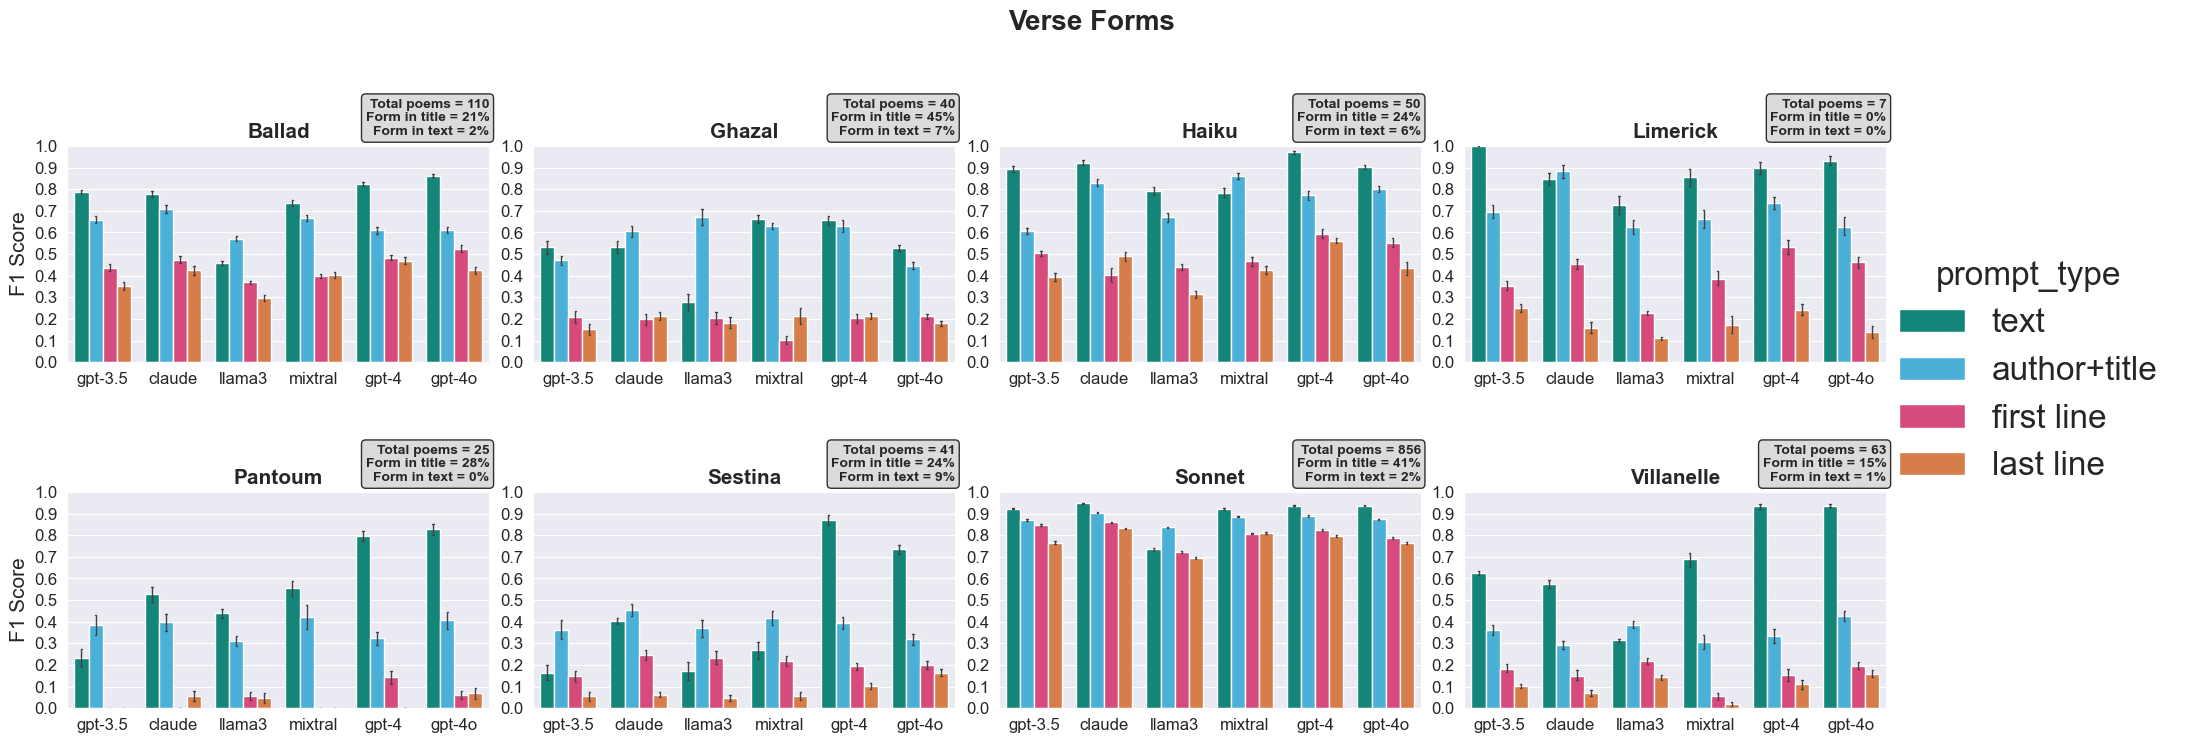

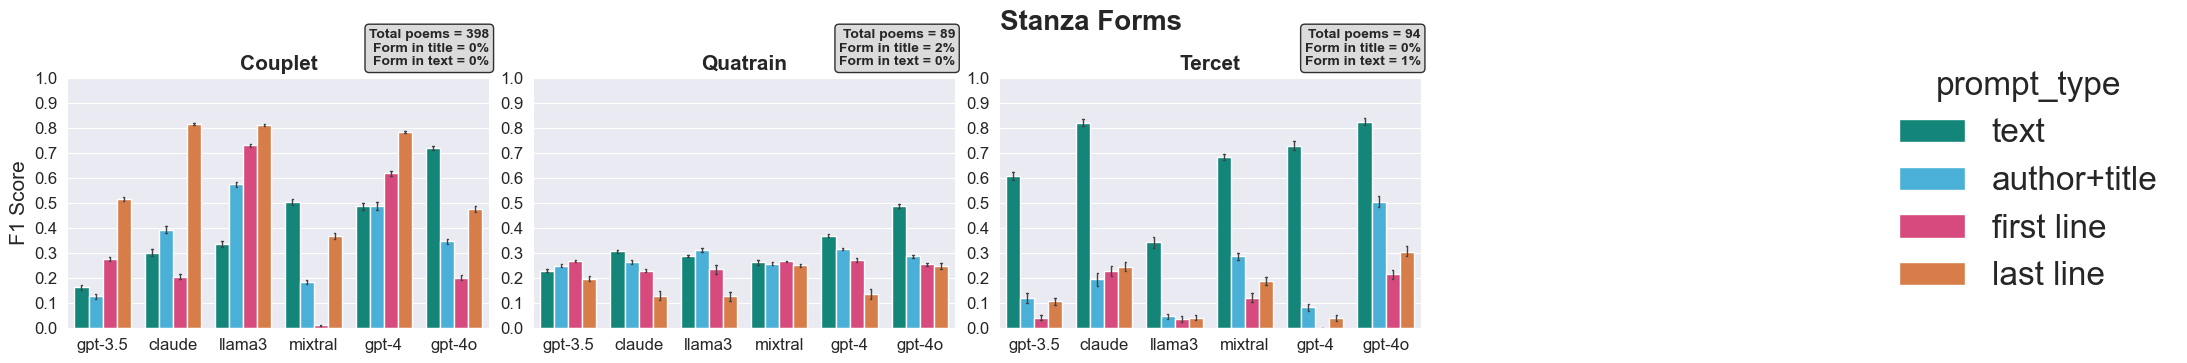

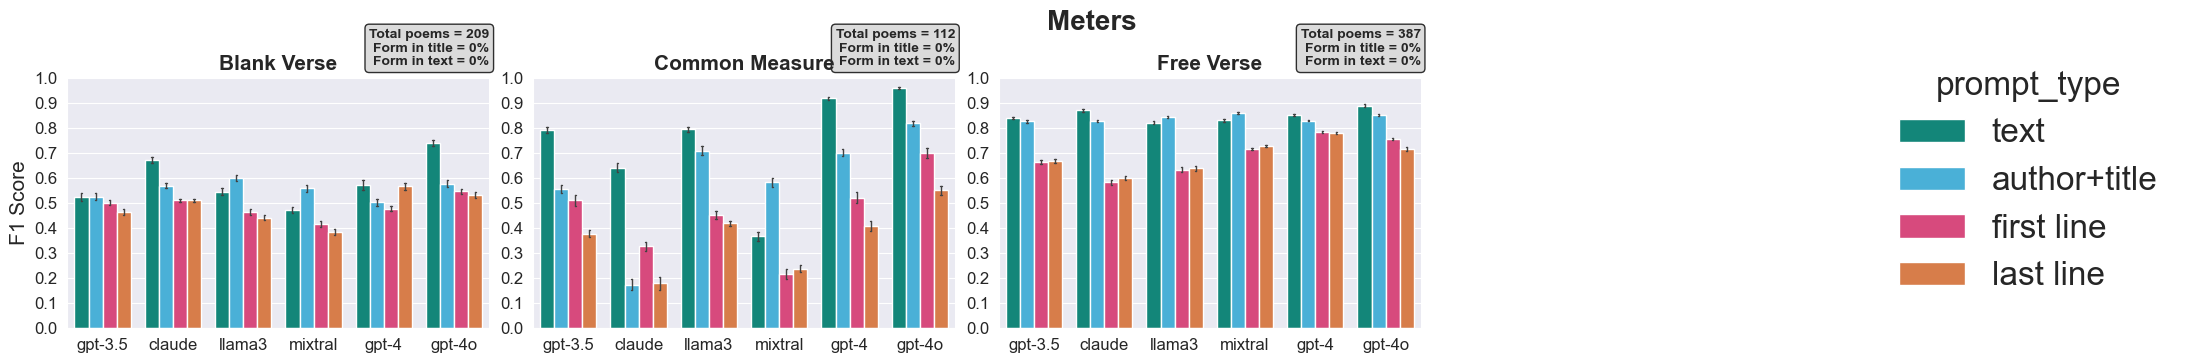

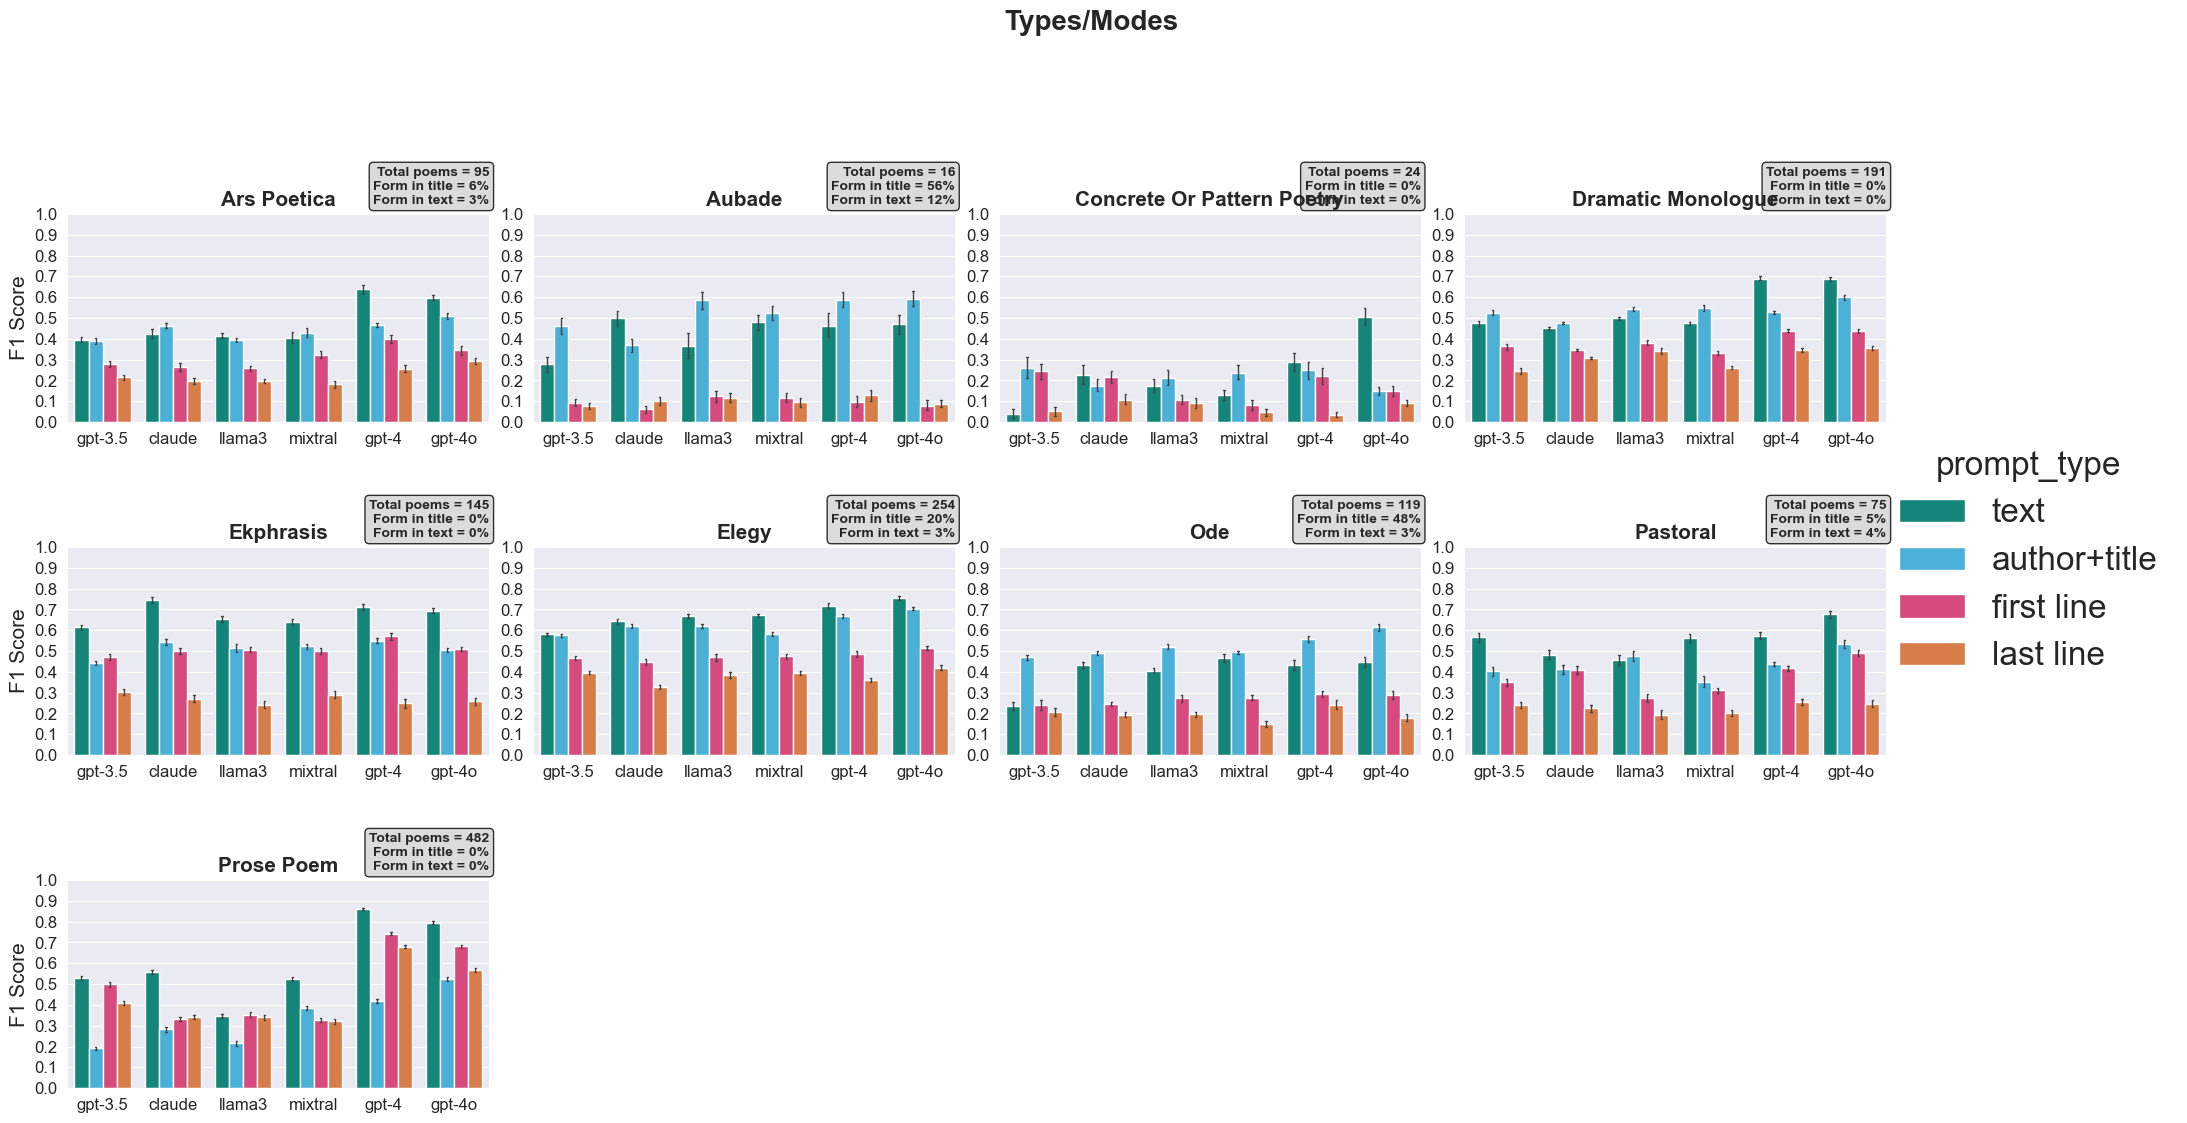

In [737]:
plot_df = bootstrap_scores_df

sns.set_style("ticks",{'axes.grid' : True})
sns.set_style("darkgrid")

def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    ax.text(.1, .6, f"N = {n}", transform=ax.transAxes)

with sns.plotting_context(rc={"legend.fontsize":24, "legend.title_fontsize":24, 'axes.labelsize':15}):
    
    # Loop through each form and make a catplot
    for form in ['verse forms', 'stanza forms', 'meters', 'types/modes']: 

        form_df = plot_df[plot_df['form_group'] == form].copy()

        g = sns.catplot(
            data=plot_df[plot_df['form_group'] == form], kind="bar", col = "label", 
            aspect = 1.2, height = 4, 
            col_wrap = 4, 
            errwidth = 1,
            x="model", y="F1", hue="prompt_type", 
            hue_order=[ 'text', 'author+title', 'first line', 'last line'], 
            order = ['gpt-3.5-turbo', 'claude-3-sonnet-20240229', 'meta/meta-llama-3-70b-instruct', 'open-mixtral-8x22b',  'gpt-4', 'gpt-4o', ],
            capsize = .02,
      
              palette= sns.color_palette([
                  # https://cran.r-project.org/web/packages/khroma/vignettes/tol.html
                  # Paul Tol's bright color-blind safe palette:
                 # "#33BBEE", "#EE3377", "#009988", "#EE7733",
                  # Paul Tol's light color-blind mostly friendly palette:
                 # "#77AADD", "#EE8866", "#EEDD88", "#44BB99",
                  # Paul Tol's vibrant color-blind safe:
                "#009988",    "#33BBEE",  "#EE3377", "#EE7733",
                 # "#0077BB",  
                  #"#CC3311",  "#BBBBBB", 

                  #"#FFAABB", "#99DDFF",  "#BBCC33", "#AAAA00", "#DDDDDD"

                #"#D81B60", 
                #"#1E88E5", 
                                                  #     "#6bdd39",
                                                       # "#03fcfc",  "#FFC107" 
                                                       ], 5), sharey= False,
        )
        g.set(yticks = np.arange(0, 1.1, 0.1)) # <--- set the ticks first

        g.set_titles("{col_name}", weight = 'bold', fontsize = 20)
        g.set(ylim=(0, 1))

        
        # Make mini subtitles
        g.fig.subplots_adjust(top=.78, hspace = .6) 
        g.fig.suptitle(f"{form.title()}", fontsize = 20, weight = 'bold', y = .95)

        # Add annotation for the number of poems
        for ax in g.axes.flat:
            form_name = ax.get_title().lower()

            num_poems_with_form_in_text = poem_tag_df[(poem_tag_df['form_group'] == form) & (poem_tag_df['form'] == form_name) & (poem_tag_df['form_in_text'] == "yes")].drop_duplicates(subset = ["poem_text"]).shape[0]

            num_poems_with_form_in_title = poem_tag_df[(poem_tag_df['form_group'] == form) & (poem_tag_df['form'] == form_name) & (poem_tag_df['form_in_title'] == "yes")].drop_duplicates(subset = ["poem_text"]).shape[0]

            num_poems = poem_tag_df[(poem_tag_df['form_group'] == form) & (poem_tag_df['form'] == form_name)].drop_duplicates(subset = ["poem_text"]).shape[0]
            
            # Add annotation box with number of poems with form in title or text
            ax.annotate(f'Total poems = {num_poems}\nForm in title = {math.floor((num_poems_with_form_in_title / num_poems)* 100)}%\nForm in text = {math.floor((num_poems_with_form_in_text / num_poems)* 100)}%', 
                        xy=(1, 1.05), 
                        xycoords='axes fraction', fontsize=10, weight='bold',
                        ha='right',
                        transform=ax.transAxes,
                bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey', alpha=0.8))
        

        #set x labels on every plot
        for i, ax in enumerate(g.axes):
            ax.set_xticklabels(['gpt-3.5', 'claude',  'llama3', 'mixtral', 'gpt-4', 'gpt-4o'], rotation=0)

            ax.tick_params(labelbottom=True)
            ax.tick_params(labelsize=12)  # Change the tick label size here
            ax.set_xlabel('')  # Remove x-axis labels

            if i % 4 == 0:  
                ax.set_ylabel('F1 Score')  # Set y-axis label only for the leftmost plot
            else:
                ax.set_ylabel('')  # Remove y-axis labels for other plots
            

  

# Individual Plots

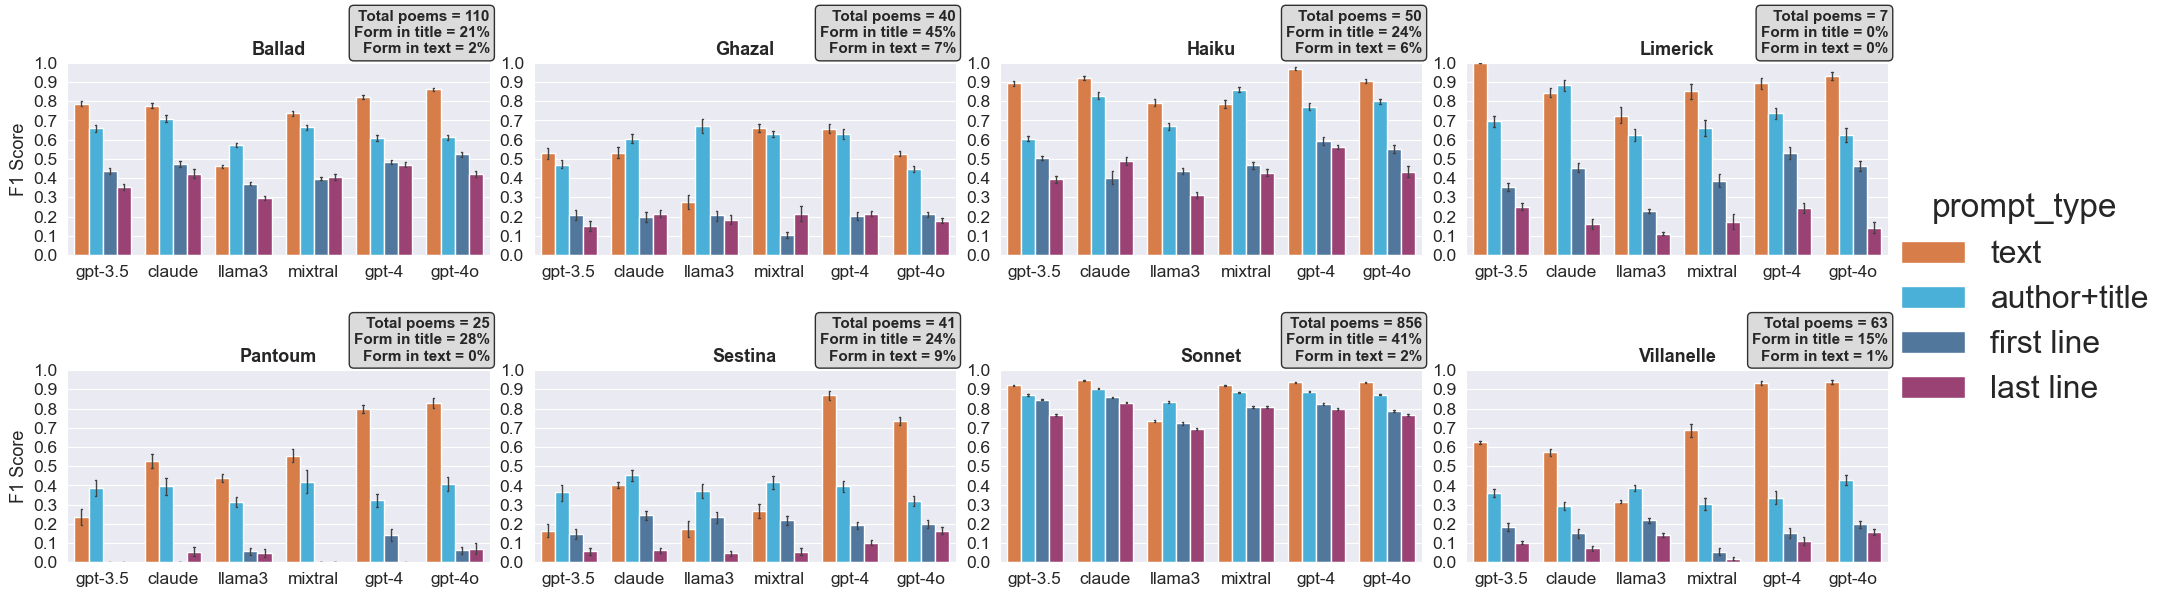

In [764]:
plot_df = bootstrap_scores_df

sns.set_style("ticks",{'axes.grid' : True})
sns.set_style("darkgrid")


def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    ax.text(.1, .6, f"N = {n}", transform=ax.transAxes)

with sns.plotting_context(rc={"legend.fontsize":23, "legend.title_fontsize":24, 'axes.labelsize':13}):
    # Loop through each form and make a catplot
    form = "verse forms"

    g = sns.catplot(
        data=plot_df[plot_df['form_group'] == "verse forms"], kind="bar", col = "label", 
        aspect = 1.2, height = 4, 
        col_wrap = 4, 
        errwidth = 1,
        x="model", y="F1", hue="prompt_type", 
        hue_order=[ 'text', 'author+title', 'first line', 'last line'], 
      order = ['gpt-3.5-turbo', 'claude-3-sonnet-20240229', 'meta/meta-llama-3-70b-instruct', 'open-mixtral-8x22b',  'gpt-4', 'gpt-4o', ],
        capsize = .02,
    
            palette= sns.color_palette([
                # https://cran.r-project.org/web/packages/khroma/vignettes/tol.html
                # Paul Tol's bright color-blind safe palette:
                # [, "#EE6677", "#228833", "#CCBB44", "#66CCEE", "#AA3377", "#BBBBBB", ]

                "#EE7733","#33BBEE", "#4477AA",  "#AA3377",
                "#009988", "#EE3377",
                  # ,
                # Paul Tol's light color-blind mostly friendly palette:
                # "#77AADD", "#EE8866", "#EEDD88", "#44BB99",
                # Paul Tol's vibrant color-blind safe:
           # "#009988",    "#33BBEE",  "#EE3377", "#EE7733",
                # "#0077BB",  
                #"#CC3311",  "#BBBBBB", 

                #"#FFAABB", "#99DDFF",  "#BBCC33", "#AAAA00", "#DDDDDD"

            #"#D81B60", 
            #"#1E88E5", 
                                                #     "#6bdd39",
                                                    # "#03fcfc",  "#FFC107" 
                                                    ], 5), sharey= False,
    )
    g.set(yticks = np.arange(0, 1.1, 0.1)) # <--- set the ticks first

    g.set_titles("{col_name}", weight = 'bold', fontsize = 35)
    g.set(ylim=(0, 1))

    
    # Make mini subtitles
    g.fig.subplots_adjust(top=.7, hspace = .6) 

    # Add annotation for the number of poems
    for ax in g.axes.flat:

        form_name = ax.get_title().lower()

        num_poems_with_form_in_text = poem_tag_df[(poem_tag_df['form_group'] == form) & (poem_tag_df['form'] == form_name) & (poem_tag_df['form_in_text'] == "yes")].drop_duplicates(subset = ["poem_text"]).shape[0]

        num_poems_with_form_in_title = poem_tag_df[(poem_tag_df['form_group'] == form) & (poem_tag_df['form'] == form_name) & (poem_tag_df['form_in_title'] == "yes")].drop_duplicates(subset = ["poem_text"]).shape[0]

        num_poems = poem_tag_df[(poem_tag_df['form_group'] == form) & (poem_tag_df['form'] == form_name)].drop_duplicates(subset = ["poem_text"]).shape[0]
        
        # Add annotation box with number of poems with form in title or text
        ax.annotate(f'Total poems = {num_poems}\nForm in title = {math.floor((num_poems_with_form_in_title / num_poems)* 100)}%\nForm in text = {math.floor((num_poems_with_form_in_text / num_poems)* 100)}%', 
                    xy=(1, 1.05), 
                    xycoords='axes fraction', fontsize=11, weight='bold',
                    ha='right',
                    transform=ax.transAxes,
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey', alpha=0.8))
    

    #set x labels on every plot
    for i, ax in enumerate(g.axes):
        ax.set_xticklabels(['gpt-3.5', 'claude',  'llama3', 'mixtral', 'gpt-4', 'gpt-4o'], rotation=0)

        ax.tick_params(labelbottom=True)
        ax.tick_params(labelsize=12.5)  # Change the tick label size here
        ax.set_xlabel('')  # Remove x-axis labels

        if i % 4 == 0:  # Check if the plot is in the first column
            ax.set_ylabel('F1 Score')  # Set y-axis label only for the leftmost plot
        else:
            ax.set_ylabel('')  # Remove y-axis labels for other plots

plt.savefig('fixed-forms_f1-bootstrap-20_high-res.png', dpi=300)


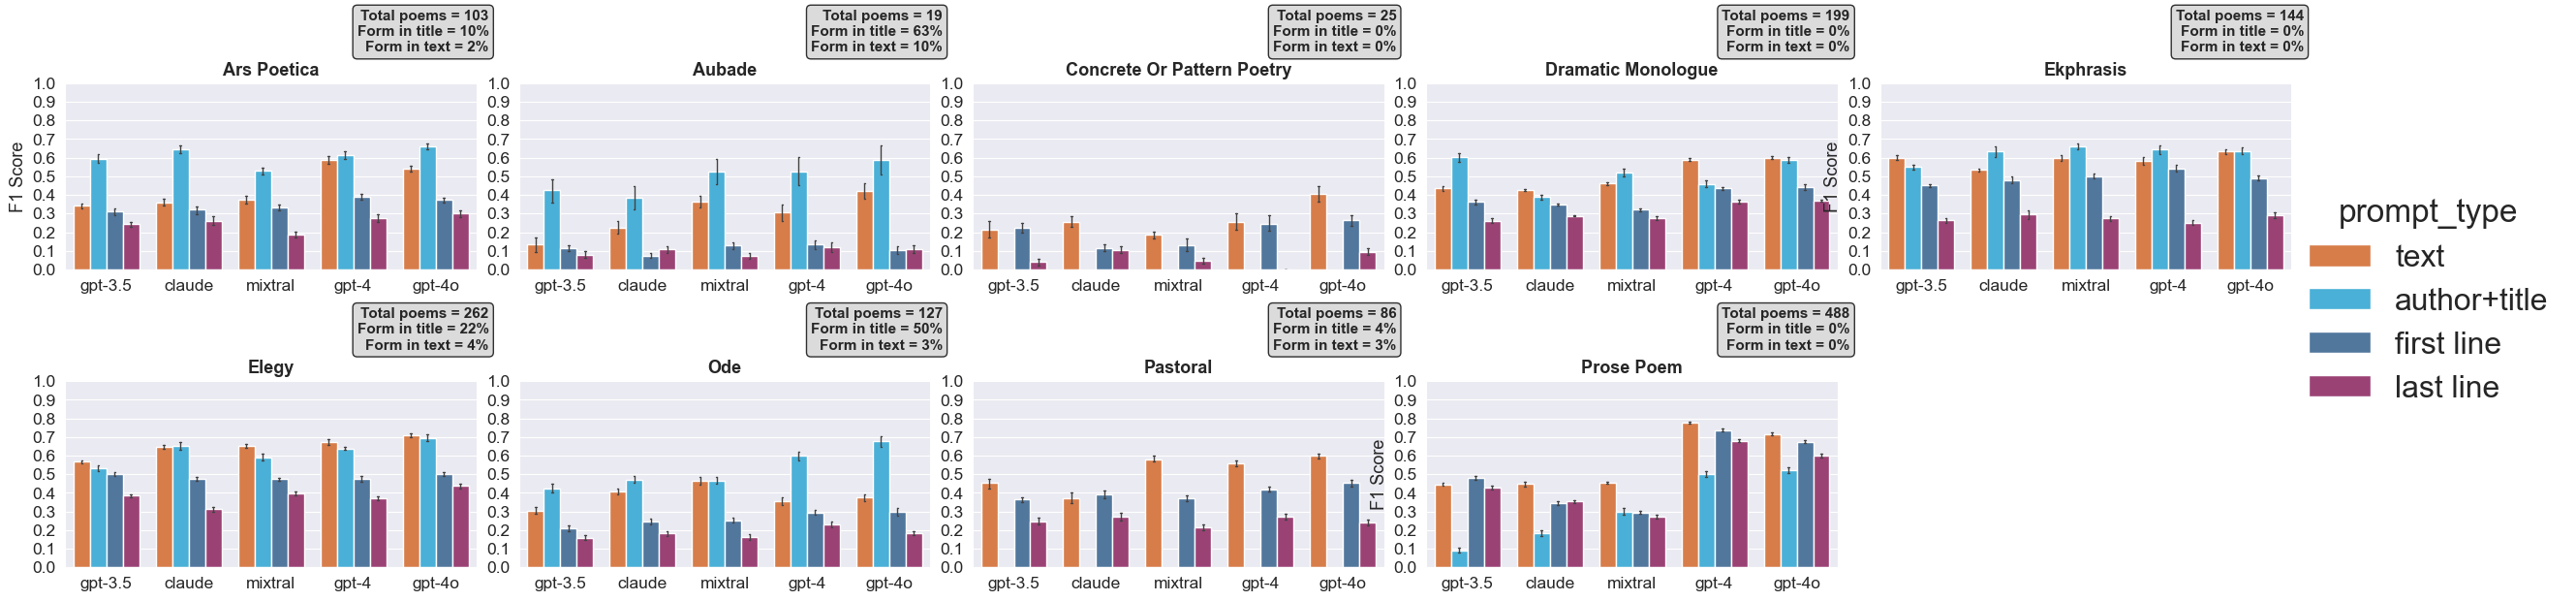

In [693]:
plot_df = scores_df

sns.set_style("ticks",{'axes.grid' : True})
sns.set_style("darkgrid")

def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    ax.text(.1, .6, f"N = {n}", transform=ax.transAxes)

with sns.plotting_context(rc={"legend.fontsize":23, "legend.title_fontsize":24, 'axes.labelsize':13}):
    
    # Loop through each form and make a catplot
    form = "types/modes"

    g = sns.catplot(
        data=plot_df[plot_df['form_group'] == form], kind="bar", col = "label", 
        aspect = 1.2, height = 4, 
        col_wrap = 5, 
        #row = "form_group",
        errwidth = 1,
        x="model", y="F1", hue="prompt_type", 
        hue_order=[ 'text', 'author+title', 'first line', 'last line'], 
        order = ['gpt-3.5-turbo', 'claude-3-sonnet-20240229', 'open-mixtral-8x22b',  'gpt-4', 'gpt-4o', ],
        capsize = .02,
    
            palette= sns.color_palette([
                # https://cran.r-project.org/web/packages/khroma/vignettes/tol.html
                # Paul Tol's bright color-blind safe palette:
                    "#EE7733","#33BBEE", "#4477AA",  "#AA3377",
                "#009988", "#EE3377",
                # Paul Tol's light color-blind mostly friendly palette:
                # "#77AADD", "#EE8866", "#EEDD88", "#44BB99",
                # Paul Tol's vibrant color-blind safe:
            #"#009988",    "#33BBEE",  "#EE3377", "#EE7733",
                # "#0077BB",  
                #"#CC3311",  "#BBBBBB", 

                #"#FFAABB", "#99DDFF",  "#BBCC33", "#AAAA00", "#DDDDDD"

            #"#D81B60", 
            #"#1E88E5", 
                                                #     "#6bdd39",
                                                    # "#03fcfc",  "#FFC107" 
                                                    ], 5), sharey= False,
    )
    g.set(yticks = np.arange(0, 1.1, 0.1)) # <--- set the ticks first

    g.set_titles("{col_name}", weight = 'bold', fontsize = 25)
    g.set(ylim=(0, 1))

    
    # Make mini subtitles

    g.fig.subplots_adjust(top=.7, hspace = .6) 
    # g.fig.suptitle(f"Unfixed Forms", fontsize = 20, weight = 'bold', y = .95)
    #plt.legend(fontsize='x-large', title_fontsize='40')


    #plt.legend(title='Prompt Type', loc='upper right', labels=['Full Text + Context (Author/Title)', 'Full Text', 'Snippet (First Line)'])

    # Add annotation for the number of poems
    for ax in g.axes.flat:

        form_name = ax.get_title().lower()

        num_poems_with_form_in_text = poem_tag_df[(poem_tag_df['form_group'] == form) & (poem_tag_df['form'] == form_name) & (poem_tag_df['form_in_text'] == "yes")].drop_duplicates(subset = ["poem_text"]).shape[0]

        num_poems_with_form_in_title = poem_tag_df[(poem_tag_df['form_group'] == form) & (poem_tag_df['form'] == form_name) & (poem_tag_df['form_in_title'] == "yes")].drop_duplicates(subset = ["poem_text"]).shape[0]

        num_poems = poem_tag_df[(poem_tag_df['form_group'] == form) & (poem_tag_df['form'] == form_name)].drop_duplicates(subset = ["poem_text"]).shape[0]
        
        # Add annotation box with number of poems with form in title or text
        ax.annotate(f'Total poems = {num_poems}\nForm in title = {math.floor((num_poems_with_form_in_title / num_poems)* 100)}%\nForm in text = {math.floor((num_poems_with_form_in_text / num_poems)* 100)}%', 
                    xy=(1.03, 1.17), 
                    xycoords='axes fraction', fontsize=11, weight='bold',
                    ha='right',
                    transform=ax.transAxes,
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey', alpha=0.8))
    

    #set x labels on every plot
    for i, ax in enumerate(g.axes):
        ax.set_xticklabels(['gpt-3.5', 'claude',  'mixtral', 'gpt-4', 'gpt-4o'], rotation=0)

        ax.tick_params(labelbottom=True)
        ax.tick_params(labelsize=12.5)  # Change the tick label size here
        ax.set_xlabel('')  # Remove x-axis labels

        if i % 4 == 0:  # Check if the plot is in the first column
            ax.set_ylabel('F1 Score')  # Set y-axis label only for the leftmost plot
        else:
            ax.set_ylabel('')  # Remove y-axis labels for other plots

plt.savefig('unfixed-forms_f1-bootstrap-20_high-res_2-rows.png', dpi=300)

  

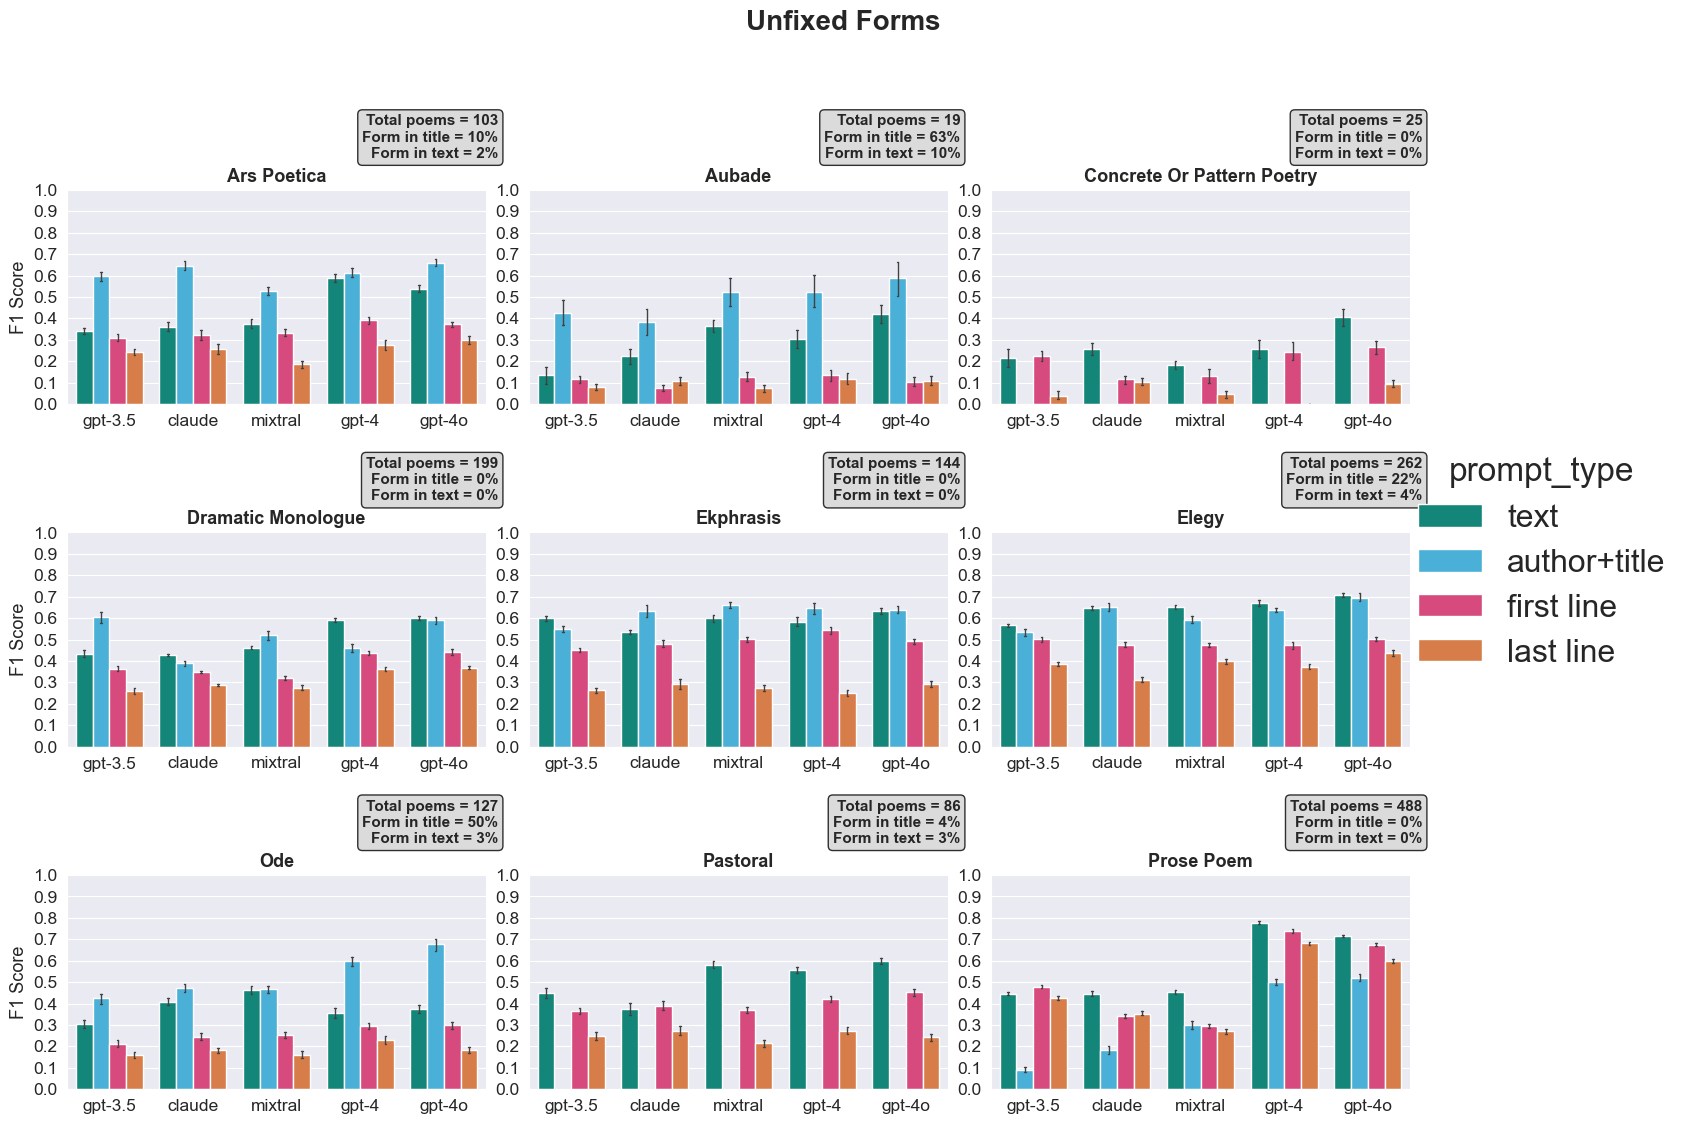

In [672]:
plot_df = scores_df

sns.set_style("ticks",{'axes.grid' : True})
sns.set_style("darkgrid")


def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    ax.text(.1, .6, f"N = {n}", transform=ax.transAxes)

with sns.plotting_context(rc={"legend.fontsize":23, "legend.title_fontsize":24, 'axes.labelsize':13}):
    # Loop through each form and make a catplot
    form = "types/modes"

    g = sns.catplot(
        data=plot_df[plot_df['form_group'] == form], kind="bar", col = "label", 
        aspect = 1.2, height = 4, 
        col_wrap = 3, 
        #row = "form_group",
        errwidth = 1,
        x="model", y="F1", hue="prompt_type", 
        hue_order=[ 'text', 'author+title', 'first line', 'last line'], 
        order = ['gpt-3.5-turbo', 'claude-3-sonnet-20240229', 'open-mixtral-8x22b',  'gpt-4', 'gpt-4o', ],
        capsize = .02,
    
            palette= sns.color_palette([
                # https://cran.r-project.org/web/packages/khroma/vignettes/tol.html
                # Paul Tol's bright color-blind safe palette:
                # "#33BBEE", "#EE3377", "#009988", "#EE7733",
                # Paul Tol's light color-blind mostly friendly palette:
                # "#77AADD", "#EE8866", "#EEDD88", "#44BB99",
                # Paul Tol's vibrant color-blind safe:
            "#009988",    "#33BBEE",  "#EE3377", "#EE7733",
                # "#0077BB",  
                #"#CC3311",  "#BBBBBB", 

                #"#FFAABB", "#99DDFF",  "#BBCC33", "#AAAA00", "#DDDDDD"

            #"#D81B60", 
            #"#1E88E5", 
                                                #     "#6bdd39",
                                                    # "#03fcfc",  "#FFC107" 
                                                    ], 5), sharey= False,
    )
    g.set(yticks = np.arange(0, 1.1, 0.1)) # <--- set the ticks first

    g.set_titles("{col_name}", weight = 'bold', fontsize = 25)
    g.set(ylim=(0, 1))

    # Make mini subtitles

    g.fig.subplots_adjust(top=.8, hspace = .6) 
    g.fig.suptitle(f"Unfixed Forms", fontsize = 20, weight = 'bold', y = .95)
    #plt.legend(fontsize='x-large', title_fontsize='40')


    #plt.legend(title='Prompt Type', loc='upper right', labels=['Full Text + Context (Author/Title)', 'Full Text', 'Snippet (First Line)'])

    # Add annotation for the number of poems
    for ax in g.axes.flat:

        form_name = ax.get_title().lower()

        num_poems_with_form_in_text = poem_tag_df[(poem_tag_df['form_group'] == form) & (poem_tag_df['form'] == form_name) & (poem_tag_df['form_in_text'] == "yes")].drop_duplicates(subset = ["poem_text"]).shape[0]

        num_poems_with_form_in_title = poem_tag_df[(poem_tag_df['form_group'] == form) & (poem_tag_df['form'] == form_name) & (poem_tag_df['form_in_title'] == "yes")].drop_duplicates(subset = ["poem_text"]).shape[0]

        num_poems = poem_tag_df[(poem_tag_df['form_group'] == form) & (poem_tag_df['form'] == form_name)].drop_duplicates(subset = ["poem_text"]).shape[0]
        
        # Add annotation box with number of poems with form in title or text
        ax.annotate(f'Total poems = {num_poems}\nForm in title = {math.floor((num_poems_with_form_in_title / num_poems)* 100)}%\nForm in text = {math.floor((num_poems_with_form_in_text / num_poems)* 100)}%', 
                    xy=(1.03, 1.15), 
                    xycoords='axes fraction', fontsize=11, weight='bold',
                    ha='right',
                    transform=ax.transAxes,
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightgrey', alpha=0.8))
    

    #set x labels on every plot
    for i, ax in enumerate(g.axes):

        #plt.xticks(rotation=90)

        #ax.set_xticklabels(set(plot_df['model'].to_list()), rotation=0)

        #ax.set_xticklabels(set(plot_df['model'].to_list()), rotation=0)
        ax.set_xticklabels(['gpt-3.5', 'claude',  'mixtral', 'gpt-4', 'gpt-4o'], rotation=0)

        ax.tick_params(labelbottom=True)
        ax.tick_params(labelsize=12.5)  # Change the tick label size here
        ax.set_xlabel('')  # Remove x-axis labels

        if i % 3 == 0:  # Check if the plot is in the first column
            ax.set_ylabel('F1 Score')  # Set y-axis label only for the leftmost plot
        else:
            ax.set_ylabel('')  # Remove y-axis labels for other plots

plt.savefig('unfixed-forms_f1-bootstrap-20_high-res.png', dpi=300)

  